In [1]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from keras.preprocessing.text import Tokenizer                    
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from sklearn.metrics import f1_score

read dataset

In [2]:
drive.mount('/content/drive')
os.chdir('drive/MyDrive/CS4248')

Mounted at /content/drive


In [3]:
train = pd.read_csv('clean_raw_data/clean_fulltrain.csv')
train.columns =['Label', 'Text']
test = pd.read_csv('clean_raw_data/clean_balancedtest.csv')
test.columns = ['Label','Text']

In [4]:
train['Label'].value_counts()


3    17870
1    14046
4     9995
2     6942
Name: Label, dtype: int64

In [5]:
class2 = train.loc[train['Label'] == 2]
class4 = train.loc[train['Label'] == 4]
class1 = train.loc[train['Label'] == 1]
class3 = train.loc[train['Label'] == 3]

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
from nltk.tokenize import sent_tokenize
import random
shuffle_sent2 = []
for i in range(class2.shape[0]):
  a = sent_tokenize(class2['Text'].iloc[i])
  random.shuffle(a)
  a = ' '.join(a)
  shuffle_sent2.append(a)
class2_sent = class2.drop("Text",axis =1 )
class2_sent['Text'] = shuffle_sent2

In [8]:
shuffle_sent2 = []
for i in range(class2.shape[0]):
  a = sent_tokenize(class2['Text'].iloc[i])
  random.shuffle(a)
  a = ' '.join(a)
  shuffle_sent2.append(a)
class2_sent = class2.drop("Text",axis =1 )
class2_sent['Text'] = shuffle_sent2

In [9]:
shuffle_sent4 = []
for i in range(class4.shape[0]):
  a = sent_tokenize(class4['Text'].iloc[i])
  random.shuffle(a)
  a = ' '.join(a)
  shuffle_sent4.append(a)
class4_sent = class4.drop("Text",axis =1 )
class4_sent['Text'] = shuffle_sent4

In [10]:
shuffle_sent3 = []
for i in range(class3.shape[0]):
  a = sent_tokenize(class3['Text'].iloc[i])
  random.shuffle(a)
  a = ' '.join(a)
  shuffle_sent3.append(a)
class3_sent = class3.drop("Text",axis =1 )
class3_sent['Text'] = shuffle_sent3

In [11]:
shuffle_sent1 = []
for i in range(class1.shape[0]):
  a = sent_tokenize(class1['Text'].iloc[i])
  random.shuffle(a)
  a = ' '.join(a)
  shuffle_sent1.append(a)
class1_sent = class1.drop("Text",axis =1 )
class1_sent['Text'] = shuffle_sent1

In [12]:
from nltk.tokenize import word_tokenize
shuffle_word2 = []
for i in range(class2.shape[0]):
  a = sent_tokenize(class2['Text'].iloc[i])
  random.shuffle(a)
  a = ' '.join(a)
  shuffle_word2.append(a)
class2_word = class2.drop("Text",axis =1 )
class2_word['Text'] = shuffle_word2

In [13]:
train = train.append(class4_sent.sample(n=8500))
train = train.append(class2_sent.sample(n=6000))
train = train.append(class2_word.sample(n=5500))
train = train.append(class3_sent.sample(n=500))
train = train.append(class1_sent.sample(n=4000))

In [ ]:
train['Label'].value_counts()


4    18495
2    18442
3    18370
1    18046
Name: Label, dtype: int64

In [ ]:
train.to_csv("balanced_train.csv",index = False)

Set weight for each type to make them balanced

The original train text.

In [15]:
train_x = train['Text'].values
test_x = test['Text'].values


### create dataset.

In [16]:
tokenizer = Tokenizer(num_words=700)
tokenizer.fit_on_texts(train_x)

In [17]:
X_train = tokenizer.texts_to_sequences(train_x)
X_test = tokenizer.texts_to_sequences(test_x)

Padding data

In [18]:
vocab_size = len(tokenizer.word_index) + 1                          

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

word2vec embedding.

In [19]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  
    # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

Golve word2vec package

In [20]:
embedding_dim = 200
embedding_matrix = create_embedding_matrix('glove.6B.200d.txt' ,
                                            tokenizer.word_index,  
                                            embedding_dim)

Create label for model, train_y.shape[48853,4]

In [21]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = enc.fit_transform(train[['Label']]).toarray()
enc_df2 = enc.fit_transform(test[['Label']]).toarray()
train_y = pd.DataFrame(enc_df)
test_y = pd.DataFrame(enc_df2)

### CNN model. 

In [23]:
from keras.models import Sequential
from keras import layers
from tensorflow import keras
from sklearn.metrics import fbeta_score
embedding_dim = 200

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.GaussianNoise(stddev=1))
model.add(layers.Conv1D(128, 7, activation='relu',kernel_regularizer=tf.keras.regularizers.l2( l2 = 0.3)))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'accuracy'])
cnn = model.fit(X_train, train_y,
                    epochs=20,
                    # validation_split=0.3,
                    shuffle = True,
                    validation_data=(X_test, test_y),
                    batch_size=64)

Epoch 1/20
1147/1147 [==============================] - 33s 18ms/step - loss: 9.0045 - precision: 0.2575 - recall: 0.0071 - accuracy: 0.3053 - val_loss: 1.4509 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.4381
Epoch 2/20
1147/1147 [==============================] - 21s 18ms/step - loss: 1.3711 - precision: 0.6667 - recall: 2.7265e-05 - accuracy: 0.4179 - val_loss: 1.4125 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.3244
Epoch 3/20
1147/1147 [==============================] - 21s 18ms/step - loss: 1.2883 - precision: 0.7966 - recall: 0.0384 - accuracy: 0.4633 - val_loss: 1.4307 - val_precision: 0.8636 - val_recall: 0.0063 - val_accuracy: 0.3398
Epoch 4/20
1147/1147 [==============================] - 20s 18ms/step - loss: 1.1372 - precision: 0.8365 - recall: 0.3028 - accuracy: 0.6242 - val_loss: 1.3716 - val_precision: 0.6677 - val_recall: 0.2954 - val_accuracy: 0.5455
Epoch 5/20
1147/1147 [==============================] - 20s 18ms/ste

Graph for 50 epoch

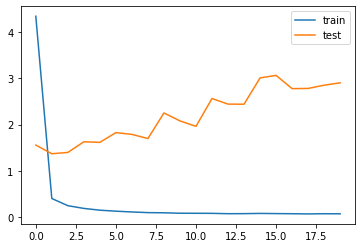

In [ ]:
import matplotlib.pyplot as plt

plt.plot(cnn.history['loss'], label='train')
plt.plot(cnn.history['val_loss'], label='test')
plt.legend()
plt.show()